In [174]:
import pandas as pd
import numpy as np
from datetime import datetime
import geopandas as gpd

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import geoplot
import geoplot.crs as gcrs

#Import Point to be able to calculate if point is within polygon
from shapely.geometry import shape, Point

# Read Airbnb listings from Broward County Florida

## The goal is to determine a model for revenue based on the characteristics of the properties.

In [175]:
# read AirBnB Listing Data into a DataFrame
air_data = pd.read_csv("../Patrick's Project/listings.csv")
print(air_data.dtypes)
print(air_data.head(5))
print(air_data.shape)


id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                           float64
dtype: object
       id                                 name  host_id  \
0   57818    Private house close to the beach!   275948   
1   69824            2 bd/2ba Oceanfront Condo   351303   
2   83449        MARY POP APTS 2/1 APT SLEEP 5   4547

In [176]:
#Convert "last_review" column to datetime... entirely for practice
air_data["last_review"]=pd.to_datetime(air_data["last_review"],format='%Y-%m-%d')

In [177]:
#Remove unnecessary columns
air_data=air_data.drop(['id','host_id','name','host_name','neighbourhood_group','number_of_reviews','calculated_host_listings_count','license'], axis = 1)

In [178]:
#Remove entries that aren't Entire home/apt
air_data = air_data[air_data['room_type']=='Entire home/apt']

In [179]:
print(air_data.head(10))

        neighbourhood  latitude  longitude        room_type  price  \
0           Hollywood  26.01670  -80.12437  Entire home/apt    235   
1    Hallandale Beach  25.97641  -80.12052  Entire home/apt    140   
2         Dania Beach  26.03392  -80.14201  Entire home/apt     99   
3   Southwest Ranches  26.04678  -80.36809  Entire home/apt    235   
4           Hollywood  25.99332  -80.11887  Entire home/apt    315   
5           Hollywood  25.99416  -80.11969  Entire home/apt    225   
7     Deerfield Beach  26.30707  -80.07793  Entire home/apt    119   
8           Hollywood  26.00746  -80.19631  Entire home/apt    284   
9           Hollywood  25.99420  -80.11725  Entire home/apt    160   
10    Fort Lauderdale  26.11784  -80.11059  Entire home/apt    650   

    minimum_nights last_review  reviews_per_month  availability_365  \
0                3  2021-10-22               0.51               337   
1               30  2021-03-27               0.04               268   
2               

In [180]:
#Room type column no longer needed
air_data=air_data.drop(['room_type'], axis = 1)

In [181]:
#Remove any properties requiring stays of more than 1 week
air_data = air_data[air_data['minimum_nights']<8]

In [182]:
#Remove any inactive properties (no reviews over last 12 months)
air_data = air_data[air_data['number_of_reviews_ltm']>0]

In [183]:
#Checking data types, mostly for last_review to ensure it is a datatime
air_data.dtypes

neighbourhood                    object
latitude                        float64
longitude                       float64
price                             int64
minimum_nights                    int64
last_review              datetime64[ns]
reviews_per_month               float64
availability_365                  int64
number_of_reviews_ltm             int64
dtype: object

In [184]:
#Reviewing summary statistics for pared down dataset
air_data.describe(include='all', datetime_is_numeric=True)

neighbourhood     latitude    longitude        price  minimum_nights  \
count           7424  7424.000000  7424.000000  7424.000000     7424.000000   
unique            33          NaN          NaN          NaN             NaN   
top        Hollywood          NaN          NaN          NaN             NaN   
freq            2151          NaN          NaN          NaN             NaN   
mean             NaN    26.098620   -80.137284   366.279903        2.658540   
min              NaN    25.966610   -80.437490    10.000000        1.000000   
25%              NaN    26.006898   -80.146324   146.000000        1.000000   
50%              NaN    26.107930   -80.123410   247.000000        2.000000   
75%              NaN    26.161920   -80.116150   430.000000        3.000000   
max              NaN    26.333410   -80.075020  8000.000000        7.000000   
std              NaN     0.097651     0.047147   433.063885        1.556403   

                          last_review  reviews_per_month  availability_365  \
count                            7424        7424.000000       7424.000000   
unique                            NaN                NaN               NaN   
top                               NaN                NaN               NaN   
freq                              NaN                NaN               NaN   
mean    2021-10-29 16:32:42.931034624           1.775686        205.091595   
min               2020-12-26 00:00:00           0.040000          0.000000   
25%               2021-10-17 00:00:00           0.680000        106.000000   
50%               2021-11-30 00:00:00           1.370000        229.000000   
75%               2021-12-12 00:00:00           2.490000        308.000000   
max               2021-12-24 00:00:00          31.110000        365.000000   
std                               NaN           1.580934        113.789684   

        number_of_reviews_ltm  
count             7424.000000  
unique                    NaN  
top                       NaN  
freq                      NaN  
mean                16.286907  
min                  1.000000  
25%                  4.000000  
50%                 11.000000  
75%                 24.000000  
max                365.000000  
std                 17.364502

In [185]:
#For investment properties, we will look more closely at the most frequently booked properties.  

In [186]:
#Columns with 90th and the 95th percentile of the data
print(air_data.quantile(q=0.90))
print(air_data.quantile(q=0.95))

latitude                  26.234232
longitude                -80.096325
price                    734.000000
minimum_nights             5.000000
reviews_per_month          3.740000
availability_365         347.000000
number_of_reviews_ltm     39.000000
Name: 0.9, dtype: float64
latitude                  26.285332
longitude                -80.088090
price                    999.000000
minimum_nights             6.000000
reviews_per_month          4.538500
availability_365         355.000000
number_of_reviews_ltm     48.000000
Name: 0.95, dtype: float64


In [187]:
#Limiting data to the top 10% of properties based on number of reviews over the last twelve months
air_data = air_data[air_data['number_of_reviews_ltm']>=39]
print(air_data.shape)

(749, 9)


In [188]:
#Limiting data to the top 5% of properties based on number of reviews over the last twelve months
#air_data = air_data[air_data['number_of_reviews_ltm']>=48]
#print(air_data.shape)



In [189]:
#Examining average price by neighbourhood
air_data.groupby('neighbourhood', as_index=False)['price'].mean()

neighbourhood       price
0           Coconut Creek   84.000000
1             Cooper City  265.000000
2           Coral Springs  105.000000
3             Dania Beach  281.965517
4                   Davie  160.333333
5         Deerfield Beach  218.478261
6         Fort Lauderdale  196.468000
7        Hallandale Beach  304.829787
8               Hollywood  319.859031
9   Lauderdale By The Sea  145.500000
10       Lauderdale Lakes  209.000000
11       Lighthouse Point  147.000000
12                Margate   67.000000
13                Miramar  237.777778
14           Oakland Park  200.800000
15         Pembroke Pines  191.777778
16             Plantation  235.833333
17          Pompano Beach  223.775000
18        Sea Ranch Lakes  239.000000
19      Southwest Ranches  175.000000
20                Sunrise  224.400000
21              West Park   74.833333
22          Wilton Manors  191.441176

In [190]:
#Looking at the number of properties in each neighborhoor
print(air_data['neighbourhood'].value_counts())

Fort Lauderdale          250
Hollywood                227
Hallandale Beach          47
Pompano Beach             40
Wilton Manors             34
Oakland Park              30
Dania Beach               29
Deerfield Beach           23
Lauderdale By The Sea     20
Pembroke Pines             9
Miramar                    9
West Park                  6
Plantation                 6
Sunrise                    5
Davie                      3
Lighthouse Point           2
Lauderdale Lakes           2
Coral Springs              2
Margate                    1
Coconut Creek              1
Sea Ranch Lakes            1
Southwest Ranches          1
Cooper City                1
Name: neighbourhood, dtype: int64


In [191]:
#Limiting data to the neighbourhoods with at least 3 properties
v = air_data.neighbourhood.value_counts()
air_data=air_data[air_data.neighbourhood.isin(v.index[v.gt(2)])]
print(air_data['neighbourhood'].value_counts())

Fort Lauderdale          250
Hollywood                227
Hallandale Beach          47
Pompano Beach             40
Wilton Manors             34
Oakland Park              30
Dania Beach               29
Deerfield Beach           23
Lauderdale By The Sea     20
Pembroke Pines             9
Miramar                    9
Plantation                 6
West Park                  6
Sunrise                    5
Davie                      3
Name: neighbourhood, dtype: int64


In [192]:
air_data.shape

(738, 9)

In [193]:
#Examining average price in each neighborhood again
air_data.groupby('neighbourhood', as_index=True)['price'].mean().sort_values(ascending=False)


neighbourhood
Hollywood                319.859031
Hallandale Beach         304.829787
Dania Beach              281.965517
Miramar                  237.777778
Plantation               235.833333
Sunrise                  224.400000
Pompano Beach            223.775000
Deerfield Beach          218.478261
Oakland Park             200.800000
Fort Lauderdale          196.468000
Pembroke Pines           191.777778
Wilton Manors            191.441176
Davie                    160.333333
Lauderdale By The Sea    145.500000
West Park                 74.833333
Name: price, dtype: float64

# Read in GeoJSON file from Airbnb defining neighbourhoods in Broward County, Florida

- This file contains multipoint polygons
- We will create a Geopandas dataframe

In [194]:
#Read in GeoJSON file for neighbourhoods in Broward County
fname="../Patrick's Project/neighbourhoods.geojson"
gj = gpd.read_file(fname)
#Print Column Headers
print(gj.columns)

Index(['neighbourhood', 'neighbourhood_group', 'geometry'], dtype='object')


In [195]:
print(gj.head())

     neighbourhood neighbourhood_group  \
0   Unincorporated                None   
1  Fort Lauderdale                None   
2   Unincorporated                None   
3   Unincorporated                None   
4      Dania Beach                None   

                                            geometry  
0  MULTIPOLYGON (((-80.17939 26.32321, -80.18039 ...  
1  MULTIPOLYGON (((-80.14737 26.19787, -80.14737 ...  
2  MULTIPOLYGON (((-80.29689 26.35266, -80.29689 ...  
3  MULTIPOLYGON (((-80.22163 26.33267, -80.22276 ...  
4  MULTIPOLYGON (((-80.20522 26.04778, -80.20515 ...  


In [196]:
print(gj.columns)

for i in range(len(gj.index)):
    gj['coordinates'] = gj['geometry'][i].representative_point()

Index(['neighbourhood', 'neighbourhood_group', 'geometry'], dtype='object')


In [197]:
gj.head()

neighbourhood neighbourhood_group  \
0   Unincorporated                None   
1  Fort Lauderdale                None   
2   Unincorporated                None   
3   Unincorporated                None   
4      Dania Beach                None   

                                            geometry  \
0  MULTIPOLYGON (((-80.17939 26.32321, -80.18039 ...   
1  MULTIPOLYGON (((-80.14737 26.19787, -80.14737 ...   
2  MULTIPOLYGON (((-80.29689 26.35266, -80.29689 ...   
3  MULTIPOLYGON (((-80.22163 26.33267, -80.22276 ...   
4  MULTIPOLYGON (((-80.20522 26.04778, -80.20515 ...   

                     coordinates  
0  POINT (-80.2672585 26.336648)  
1  POINT (-80.2672585 26.336648)  
2  POINT (-80.2672585 26.336648)  
3  POINT (-80.2672585 26.336648)  
4  POINT (-80.2672585 26.336648)

In [198]:
#Checking Coordinate Reference System
gj.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [199]:
#Checking DataFrame Type
print(type(gj))

<class 'geopandas.geodataframe.GeoDataFrame'>


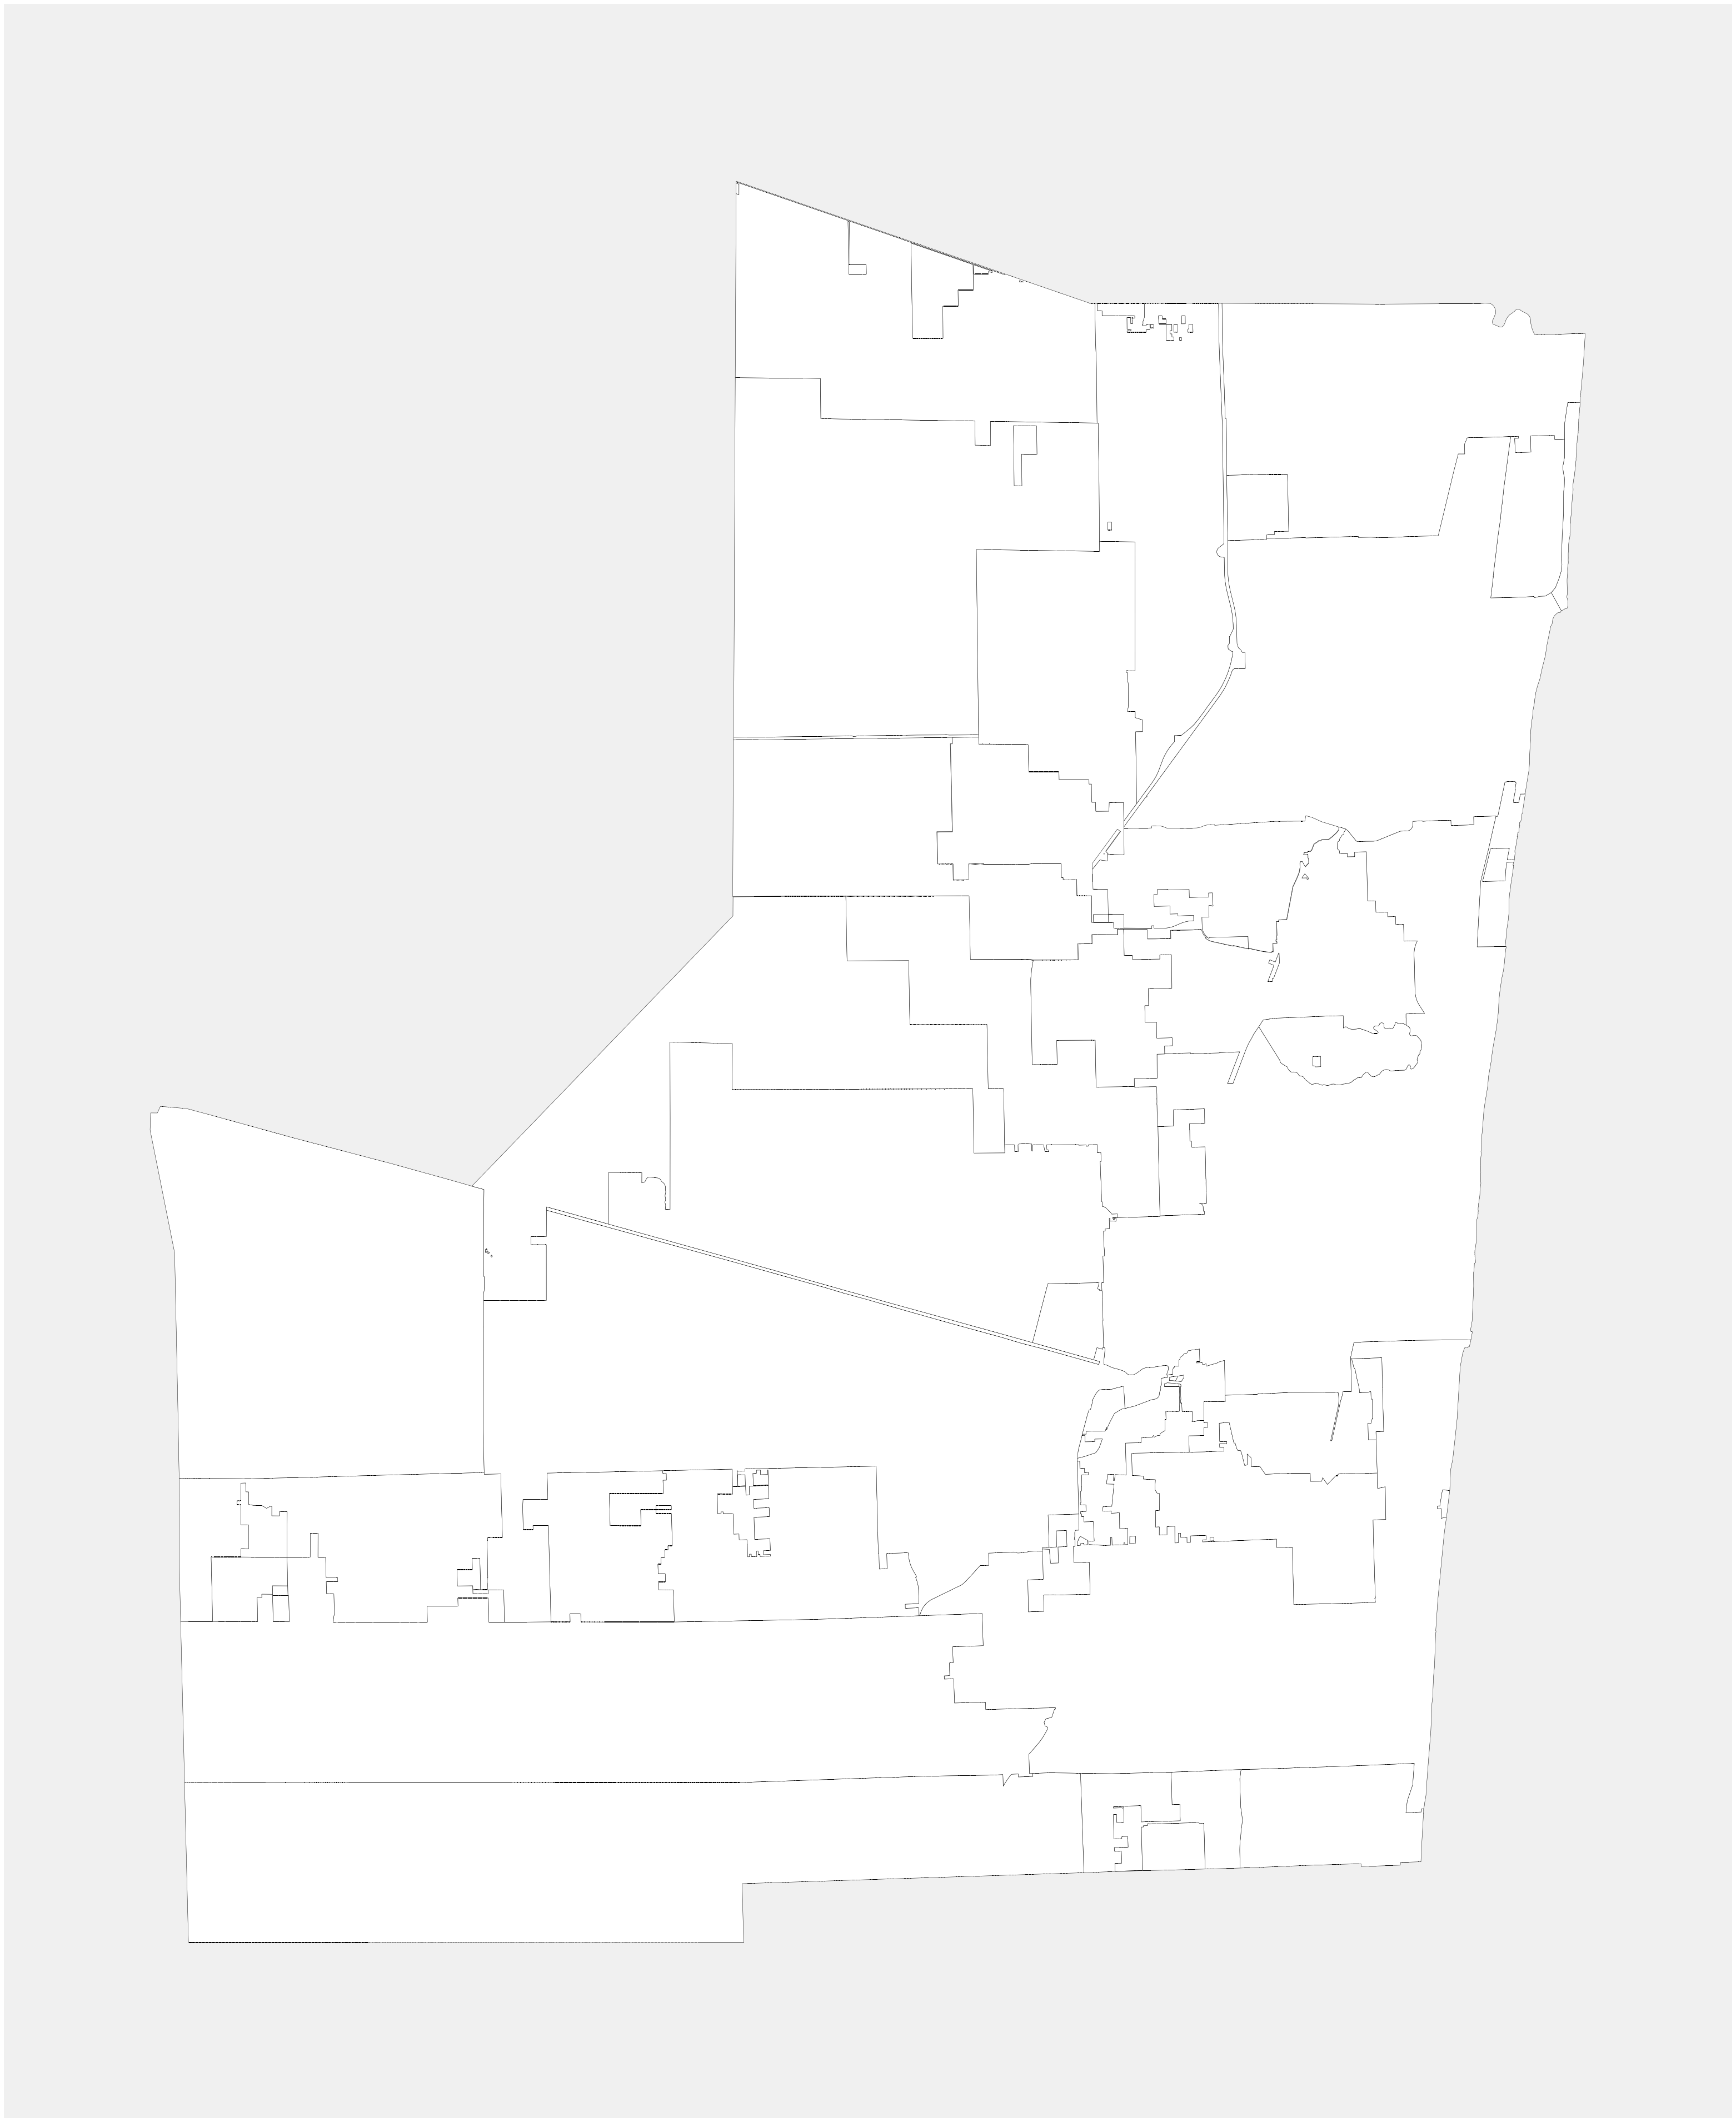

In [200]:
#Creating a polyplot of neighbourhoods in Broward County - Possible base layer when plotting current listings?  
#How do I label the neighbourhoods on the graph?
base1=geoplot.polyplot(gj, projection=gcrs.AlbersEqualArea(),edgecolor='black', facecolor='White', linewidth=.5,
    figsize=(50, 70))
#for idx, row in gj.iterrows():
    #plt.annotate(row['neighbourhood'], xy=row['coordinates'], horizontalalignment='center')

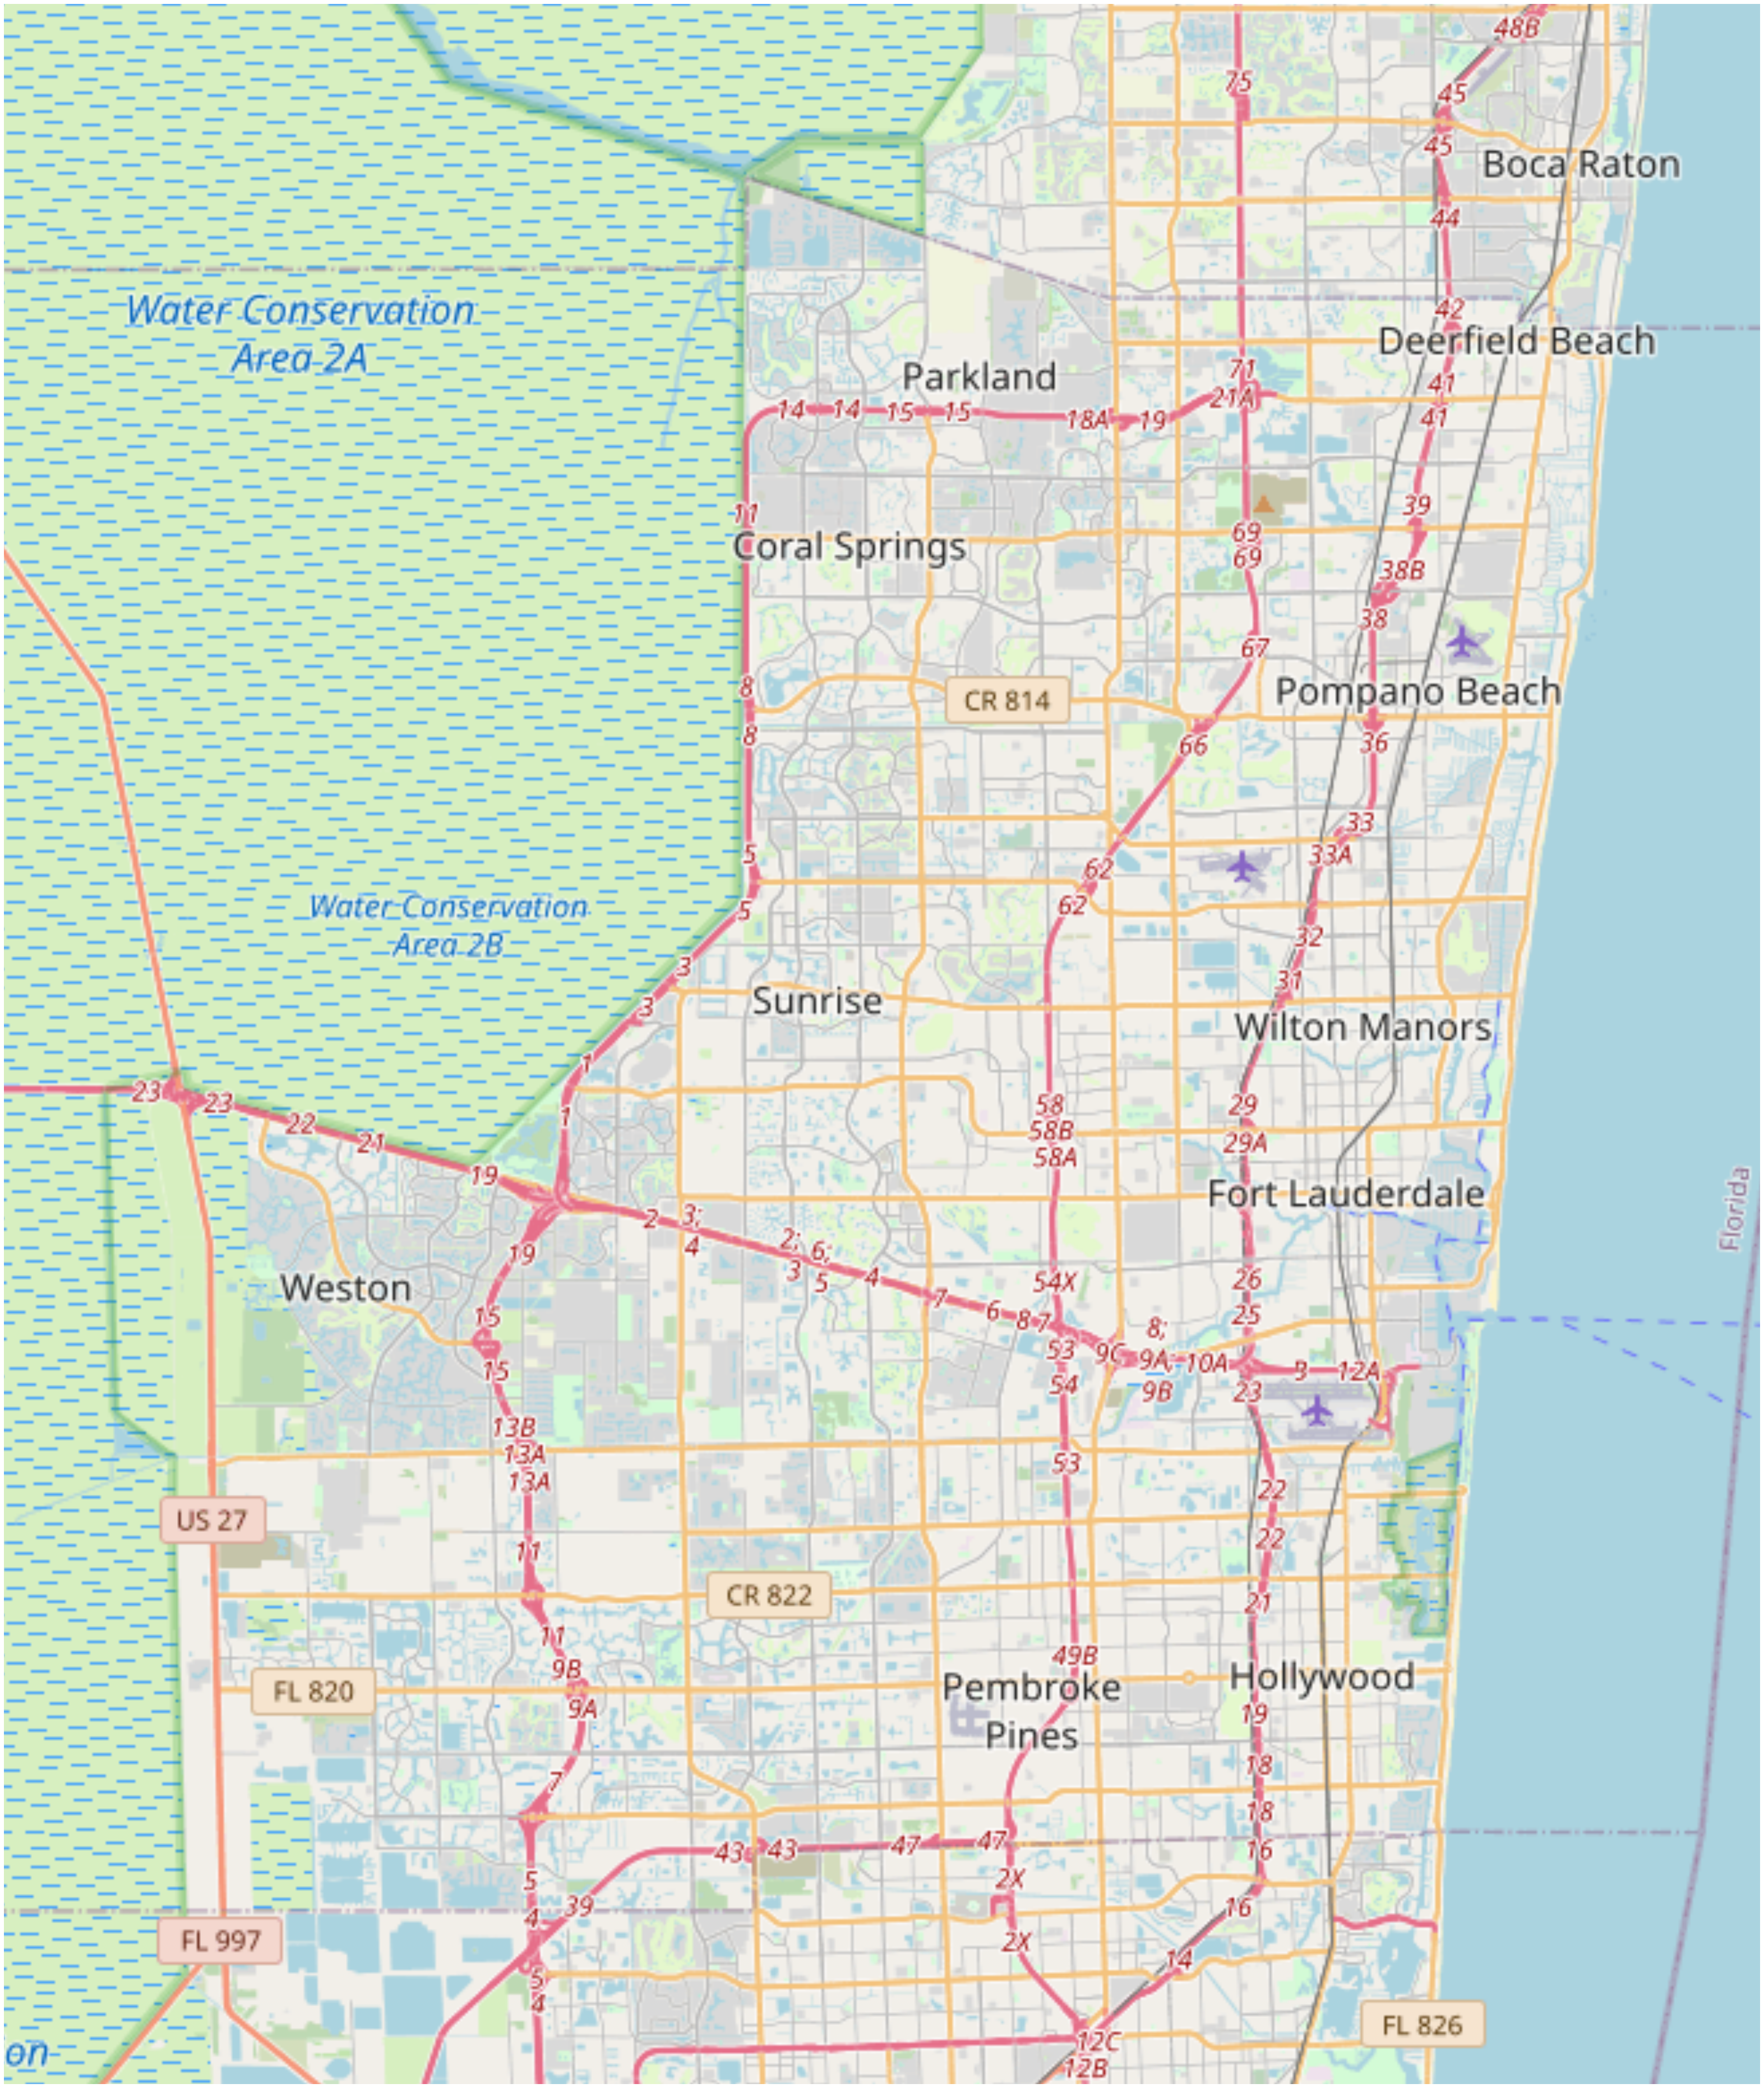

In [201]:
#Creating a geoplot of neighbourhoods in Broward County - Possible base layer when plotting current listings?  
#How do I label the neighbourhoods on the graph?
base2=geoplot.webmap(gj, projection=gcrs.WebMercator(),figsize=[50,70])

C:\Users\sande\anaconda3\envs\metis\lib\site-packages\geoplot\geoplot.py:1004: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


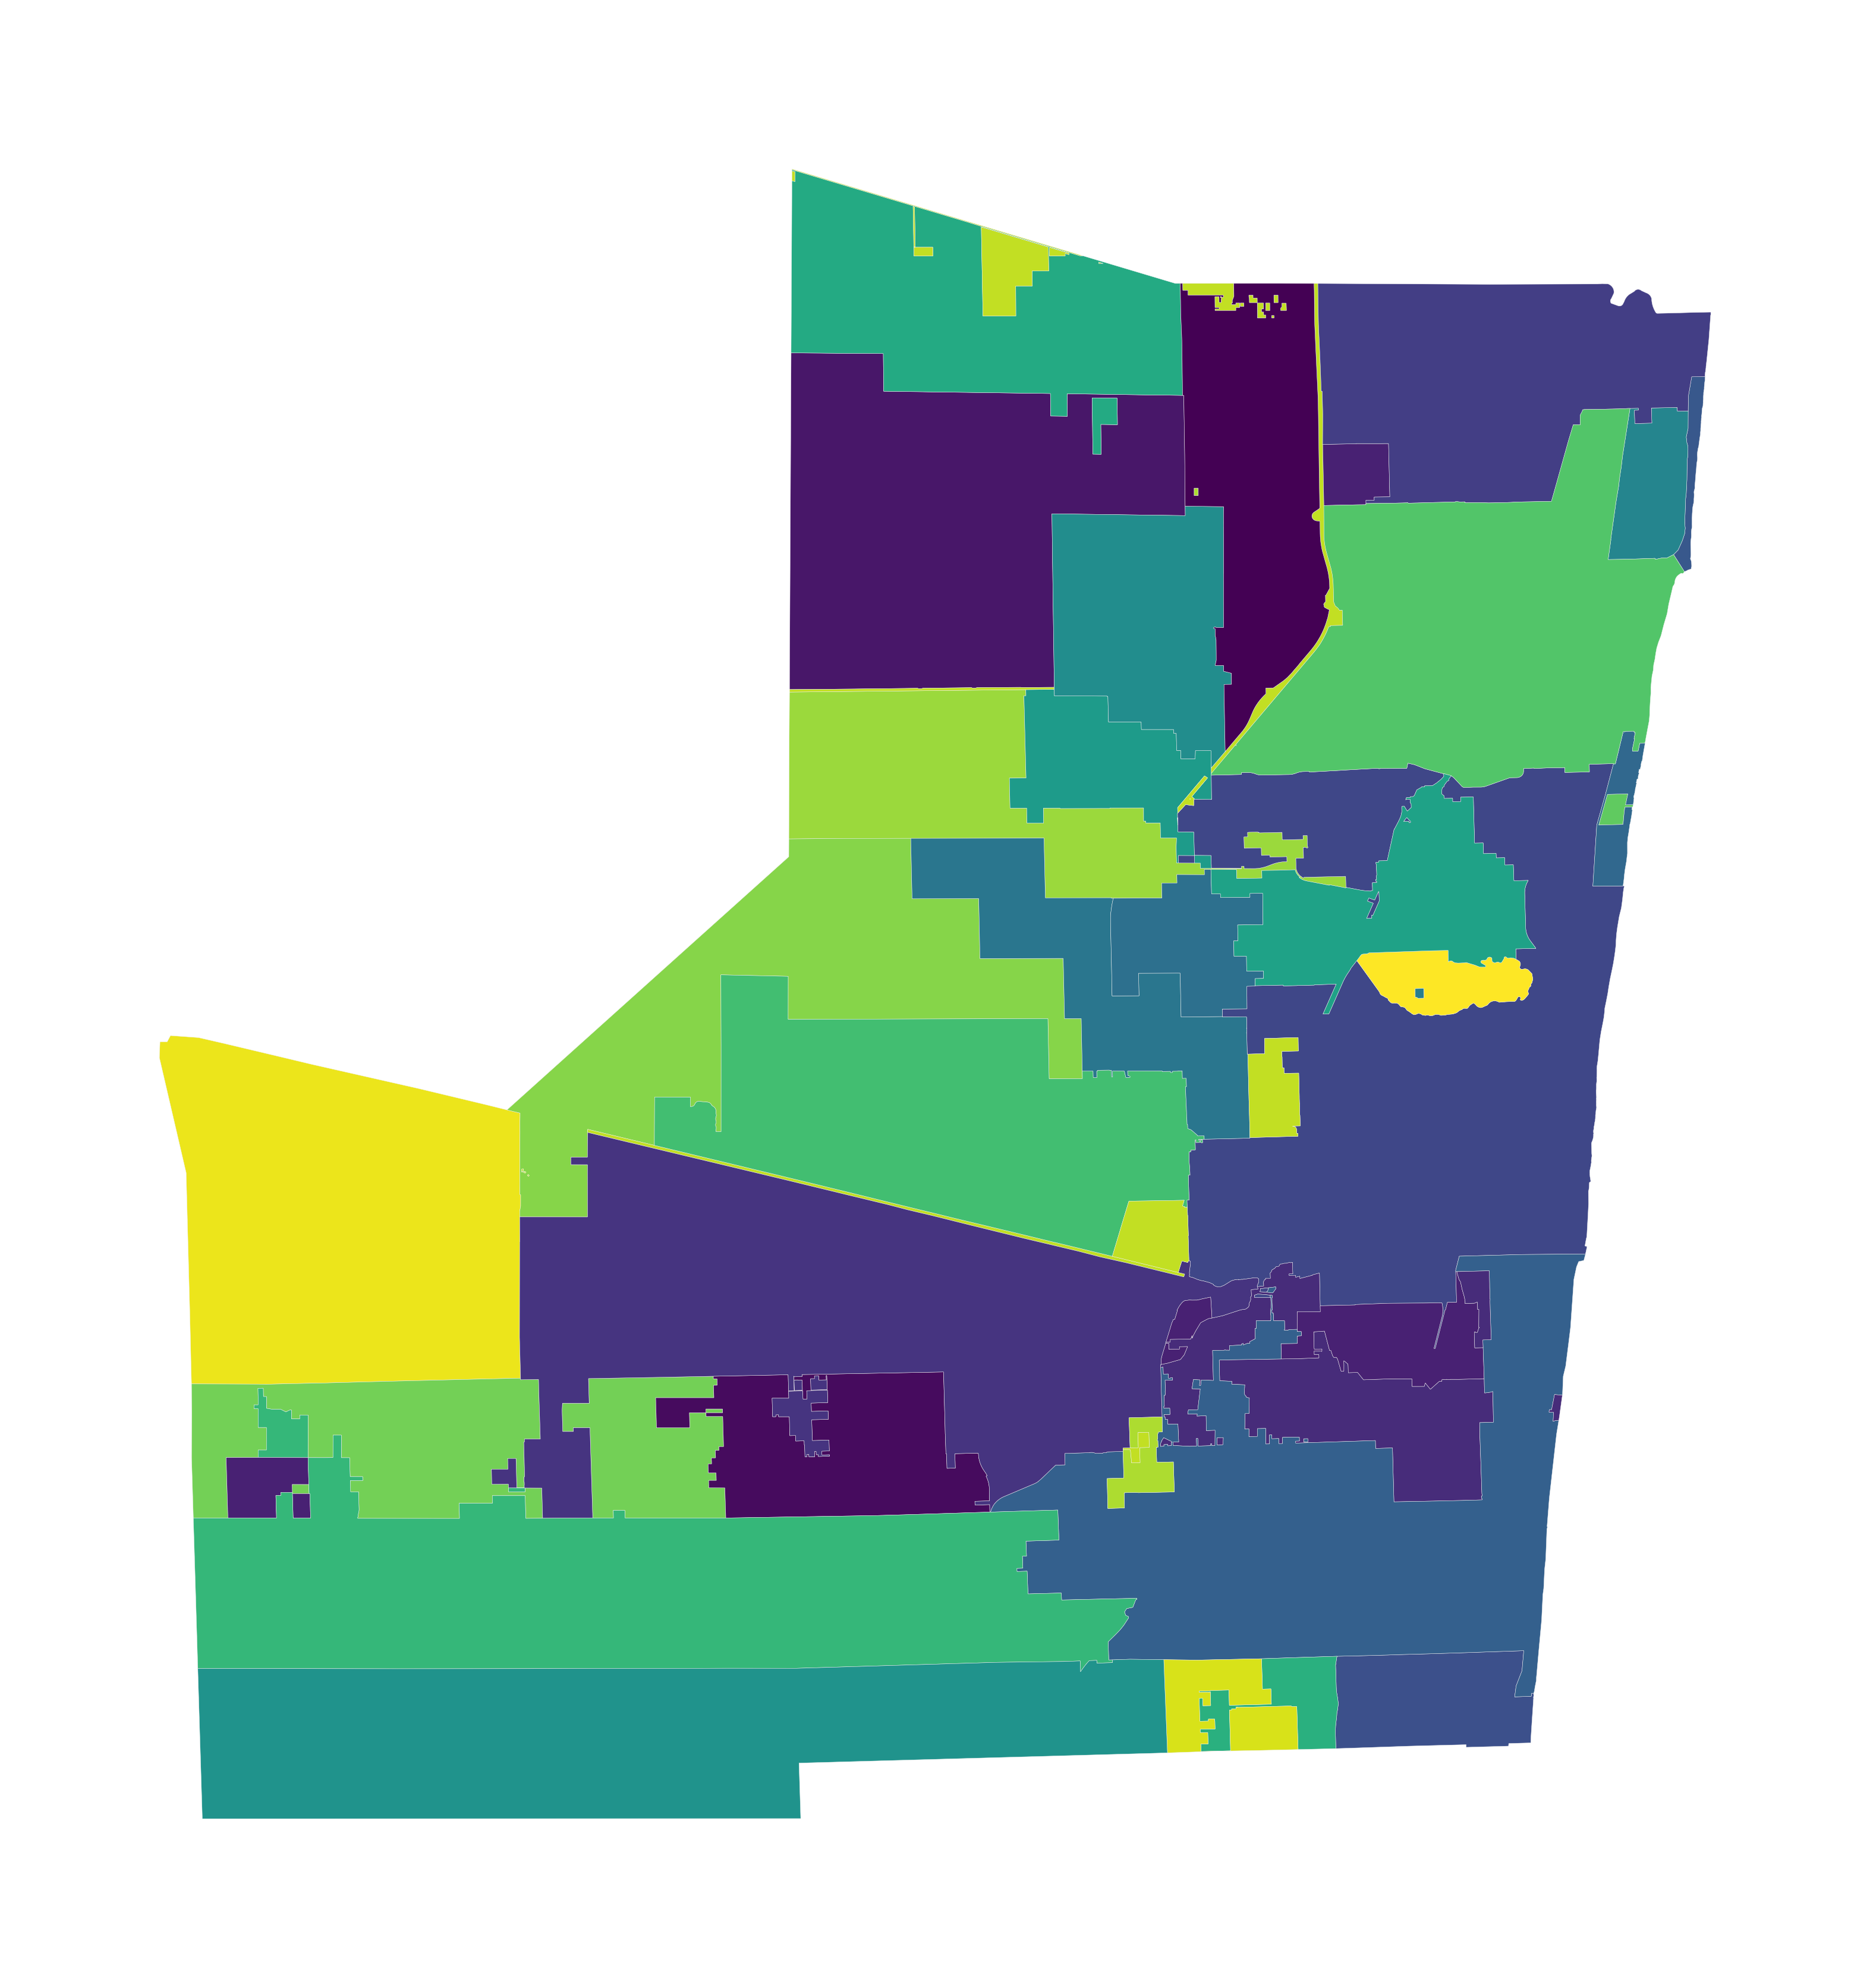

In [202]:
#Creating a Choropleth of neighbourhoods in Broward County - Possible base layer when plotting current listings?  
#How do I label the neighbourhoods on the graph?
base3=geoplot.choropleth(gj,hue='neighbourhood',figsize=[50,70])
#gj.apply(lambda x: ax.annotate(s=x.neighbourhood, xy=x.geometry.centroid.coords[0],fontsize='x-small',fontstretch='ultra-expanded',  ha='center',bbox={'facecolor': 'white', 'alpha':0.3, 'pad': 2, 'edgecolor':'none'}),axis=1,);


# Importing the current MLS listings in Broward County, FL
##### Checking to see what neighbourhoods these listings are in according to Airbnb defined neighbourhoods.

In [203]:
#Read CSV File with current MLS Listings
listings = pd.read_csv("../Patrick's Project/Current Listings.csv")

In [204]:
listings.head()

SALE TYPE  SOLD DATE              PROPERTY TYPE            ADDRESS  \
0  MLS Listing        NaN  Single Family Residential     1476 Garden Rd   
1  MLS Listing        NaN  Single Family Residential   6341 NE 20th Ter   
2  MLS Listing        NaN                  Townhouse  4738 Sundance Way   
3  MLS Listing        NaN    Multi-Family (2-4 Unit)  3820 NW 110th Ave   
4  MLS Listing        NaN  Single Family Residential   3617 NE 24th Ave   

              CITY STATE OR PROVINCE  ZIP OR POSTAL CODE    PRICE  BEDS  \
0           Weston                FL               33326   465000   2.0   
1  Fort Lauderdale                FL               33308  1150000   4.0   
2            Davie                FL               33328   425000   3.0   
3    Coral Springs                FL               33065   585000   5.0   
4  Fort Lauderdale                FL               33308  1475000   3.0   

   BATHS  ...  STATUS  NEXT OPEN HOUSE START TIME   NEXT OPEN HOUSE END TIME  \
0    2.0  ...  Active   February-26-2022 02:00 PM  February-26-2022 05:00 PM   
1    3.0  ...  Active                         NaN                        NaN   
2    2.5  ...  Active                         NaN                        NaN   
3    4.0  ...  Active                         NaN                        NaN   
4    3.0  ...  Active                         NaN                        NaN   

   URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)  \
0  https://www.redfin.com/FL/Weston/1476-Garden-R...                                             
1  https://www.redfin.com/FL/Fort-Lauderdale/6341...                                             
2  https://www.redfin.com/FL/Davie/4738-Sundance-...                                             
3  https://www.redfin.com/FL/Coral-Springs/3820-N...                                             
4  https://www.redfin.com/FL/Fort-Lauderdale/3617...                                             

   SOURCE       MLS#  FAVORITE INTERESTED   LATITUDE  LONGITUDE  
0  MARMLS  A11161439         N          Y  26.101970 -80.372803  
1  MARMLS  A11161134         N          Y  26.206156 -80.119806  
2  MARMLS  A11163135         N          Y  26.062736 -80.249863  
3  MARMLS  A11161829         N          Y  26.277885 -80.273206  
4  MARMLS  A11153195         N          Y  26.172488 -80.117014  

[5 rows x 27 columns]

In [205]:
#Select specifi columns from DataFrame
sale_list=listings[['PROPERTY TYPE','PRICE','BEDS','BATHS','LATITUDE','LONGITUDE']].copy()

In [206]:
print(sale_list.head())
print(sale_list.shape)


               PROPERTY TYPE    PRICE  BEDS  BATHS   LATITUDE  LONGITUDE
0  Single Family Residential   465000   2.0    2.0  26.101970 -80.372803
1  Single Family Residential  1150000   4.0    3.0  26.206156 -80.119806
2                  Townhouse   425000   3.0    2.5  26.062736 -80.249863
3    Multi-Family (2-4 Unit)   585000   5.0    4.0  26.277885 -80.273206
4  Single Family Residential  1475000   3.0    3.0  26.172488 -80.117014
(350, 6)


In [207]:
#Creating a GeoDataFrame and adding a point column based on (Long,Lat) data
gdf=gpd.GeoDataFrame(sale_list,geometry=gpd.points_from_xy(
    sale_list.LONGITUDE,sale_list.LATITUDE))
print(gdf)

                 PROPERTY TYPE    PRICE  BEDS  BATHS   LATITUDE  LONGITUDE  \
0    Single Family Residential   465000   2.0    2.0  26.101970 -80.372803   
1    Single Family Residential  1150000   4.0    3.0  26.206156 -80.119806   
2                    Townhouse   425000   3.0    2.5  26.062736 -80.249863   
3      Multi-Family (2-4 Unit)   585000   5.0    4.0  26.277885 -80.273206   
4    Single Family Residential  1475000   3.0    3.0  26.172488 -80.117014   
..                         ...      ...   ...    ...        ...        ...   
345                  Townhouse   260000   3.0    2.5  26.259380 -80.214833   
346                  Townhouse   315000   3.0    2.5  26.250227 -80.231914   
347  Single Family Residential   225000   2.0    2.0  26.202836 -80.280980   
348                Condo/Co-op   675000   2.0    2.0  26.007546 -80.116839   
349                  Townhouse   475000   3.0    3.0  26.065653 -80.261861   

                       geometry  
0    POINT (-80.37280 26.1019

In [208]:
#Adding a "neighbourhood" column on our GeoDataFrame
gdf["neighbourhood"] = np.nan
print(gdf.head())
print(gdf.shape)

               PROPERTY TYPE    PRICE  BEDS  BATHS   LATITUDE  LONGITUDE  \
0  Single Family Residential   465000   2.0    2.0  26.101970 -80.372803   
1  Single Family Residential  1150000   4.0    3.0  26.206156 -80.119806   
2                  Townhouse   425000   3.0    2.5  26.062736 -80.249863   
3    Multi-Family (2-4 Unit)   585000   5.0    4.0  26.277885 -80.273206   
4  Single Family Residential  1475000   3.0    3.0  26.172488 -80.117014   

                     geometry  neighbourhood  
0  POINT (-80.37280 26.10197)            NaN  
1  POINT (-80.11981 26.20616)            NaN  
2  POINT (-80.24986 26.06274)            NaN  
3  POINT (-80.27321 26.27789)            NaN  
4  POINT (-80.11701 26.17249)            NaN  
(350, 8)


In [209]:
print(gj.head())
print(gj.shape)

     neighbourhood neighbourhood_group  \
0   Unincorporated                None   
1  Fort Lauderdale                None   
2   Unincorporated                None   
3   Unincorporated                None   
4      Dania Beach                None   

                                            geometry  \
0  MULTIPOLYGON (((-80.17939 26.32321, -80.18039 ...   
1  MULTIPOLYGON (((-80.14737 26.19787, -80.14737 ...   
2  MULTIPOLYGON (((-80.29689 26.35266, -80.29689 ...   
3  MULTIPOLYGON (((-80.22163 26.33267, -80.22276 ...   
4  MULTIPOLYGON (((-80.20522 26.04778, -80.20515 ...   

                     coordinates  
0  POINT (-80.2672585 26.336648)  
1  POINT (-80.2672585 26.336648)  
2  POINT (-80.2672585 26.336648)  
3  POINT (-80.2672585 26.336648)  
4  POINT (-80.2672585 26.336648)  
(89, 4)


# Please Help With This!
### How do I add the appropriate neighbourhood to the GeoDataFrame gdf

In [210]:
#Add appropriate neighbourhood to GeoDataFrame
for a in range(350):
    point=gdf['geometry'][a]
    gdf['neighbourhood'][a]=np.nan
    for b in range(89):
        polygon=gj['geometry'][b]
        #if point.within(polygon):
        #print(a,b)
        try:
            polygon_test=polygon.contains(point)
            if polygon_test:
               gdf['neighbourhood'][a]=gj["neighbourhood"][b]
               continue
        except:
            gdf['neighbourhood'][a]="Bad Point"

                    
        #elif b==88:
                #gdf['neighbourhood'][a]="None"
        


C:\Users\sande\AppData\Local\Temp/ipykernel_3148/265649432.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['neighbourhood'][a]=np.nan
C:\Users\sande\AppData\Local\Temp/ipykernel_3148/265649432.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf['neighbourhood'][a]=gj["neighbourhood"][b]
TopologyException: side location conflict at -80.184269983050839 26.195253694915252. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -80.184269983050839 26.195253694915252. This can occur if the input geometry is invalid.
TopologyException: side location conflict at -80.18426998

In [211]:
print(gdf['neighbourhood'].value_counts())

Fort Lauderdale          57
Hollywood                25
Coral Springs            22
Pompano Beach            21
Margate                  18
Sunrise                  17
Pembroke Pines           16
Deerfield Beach          15
Davie                    15
Bad Point                15
Coconut Creek            12
Miramar                  12
Lauderdale Lakes         11
Hallandale Beach         11
Weston                   10
Lauderhill               10
Oakland Park             10
Plantation               10
Dania Beach               9
Parkland                  6
Lauderdale By The Sea     5
Lighthouse Point          4
North Lauderdale          4
Wilton Manors             4
Southwest Ranches         3
Cooper City               2
West Park                 2
Hillsboro Beach           2
Sea Ranch Lakes           1
Unincorporated            1
Name: neighbourhood, dtype: int64


In [212]:
#plt.style.use('fivethirtyeight')
#plt.figure(figsize=(13,7))
#plt.title("Neighbourhood Group")
#g = plt.pie(gdf['neighbourhood'].value_counts(), labels=gdf['neighbourhood'].value_counts().index,autopct='%1.1f%%', startangle=180)
#plt.show()

In [213]:
#gdf['neighbourhood'].value_counts()
#plt.figure(figsize=(13,7))
#plt.title("Map of Price Distribution")
#ax=air_data[air_data.price<500].plot(kind='scatter', x='longitude',y='latitude',label='Price at Various Locations',c='price',cmap=plt.get_cmap('jet'),colorbar=True,alpha=0.4)
#ax.legend()
#plt.ioff()
#plt.show()